In [ ]:
# Standard Library
import os
import time
import random
from pathlib import Path
from itertools import cycle

# Data Manipulation & Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

# Machine Learning Metrics (Scikit-Learn)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

# Transformers (Hugging Face)
from transformers import (
    ViTModel,
    ViTConfig,
    ViTFeatureExtractor,
    SequenceClassifierOutput
)

# Utilities
from tqdm import tqdm
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")

print("Path to dataset files:", path)

100%|██████████| 204M/204M [00:02<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/versions/1


In [ ]:
train_dir='/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
val_dir='/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
test_dir='/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'

## Data Preprocessing

In [ ]:
def remove_class_and_remap(dataset, class_to_remove):
    # Find the index of the class to remove
    if class_to_remove not in dataset.class_to_idx:
        print(f"Class {class_to_remove} not found in dataset.")
        return

    remove_idx = dataset.class_to_idx[class_to_remove]

    # If a label is greater than the removed index, shift it down by 1
    new_samples = []
    for path, label in dataset.samples:
        if label != remove_idx:
            new_label = label - 1 if label > remove_idx else label
            new_samples.append((path, new_label))

    # Overwrite the dataset samples
    dataset.samples = new_samples

    # Update class lists and dictionaries
    dataset.classes.remove(class_to_remove)

    # Rebuild class_to_idx mapping
    dataset.class_to_idx = {cls_name: i for i, cls_name in enumerate(dataset.classes)}

    # Update internal targets list (used for weighted sampling sometimes)
    dataset.targets = [s[1] for s in dataset.samples]


In [ ]:
# 2. Define Transforms
# ImageNet normalization stats (standard for pre-trained CNNs and ViTs)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transforms for Training (includes Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to fixed size (for CNN and ViT)
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels (R=G=B) for pre-trained models
    transforms.RandomHorizontalFlip(p=0.5),      # Augmentation: Flip left/right (valid for X-rays)
    transforms.RandomVerticalFlip(p=0.5),        # Augmentation: Flip up/down
    transforms.RandomRotation(degrees=10),       # Augmentation: Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Transforms for Validation/Test (No Augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 3. Load Data using ImageFolder
# This automatically assigns labels based on folder names (0, 1, 2, 3, 4)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

# May Remove Later
# remove_class_and_remap(train_dataset, '1')
# remove_class_and_remap(val_dataset, '1')
# remove_class_and_remap(test_dataset, '1')

# 4. Create DataLoaders
batch_size = 32 # Adjust based on your GPU memory (ViT consumes more memory)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verification
print(f"Classes found: {train_dataset.classes}") # Should be ['0', '1', '2', '3', '4']
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}") # Should be [32, 3, 224, 224]

Classes found: ['0', '1', '2', '3', '4']
Batch shape: torch.Size([32, 3, 224, 224])


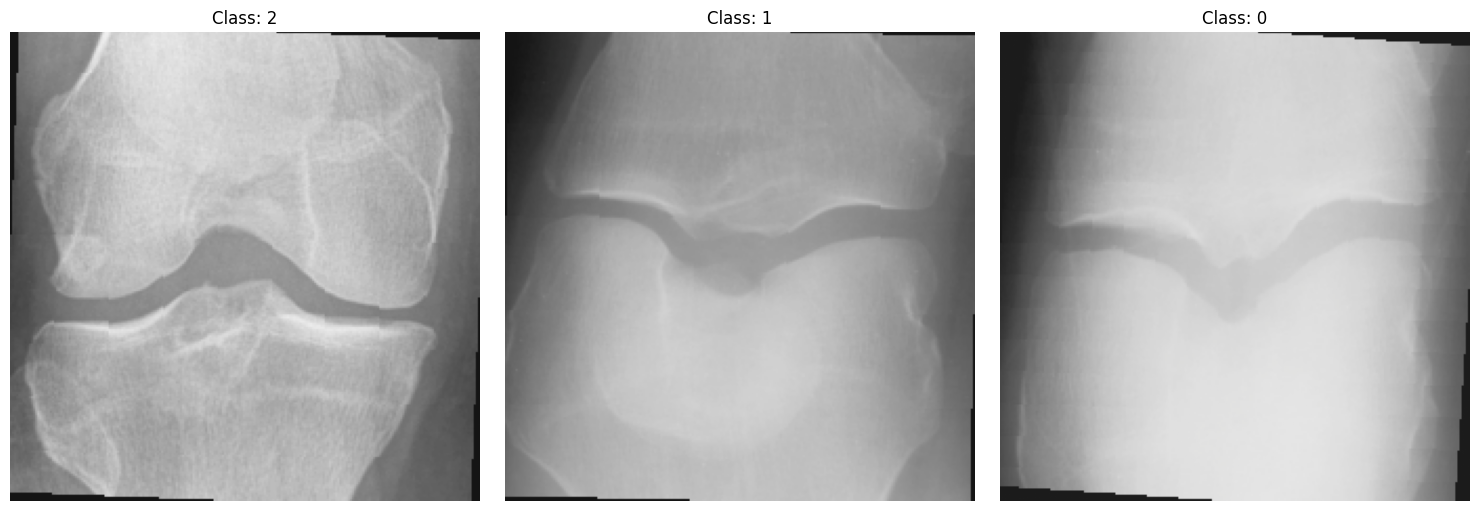

In [ ]:
num_images_to_show = 3

plt.figure(figsize=(15, 5))

for i in range(num_images_to_show):
    # Get a random index
    random_idx = random.randint(0, len(train_dataset) - 1)

    # Get the image and label (transforms are applied here)
    image_tensor, label_idx = train_dataset[random_idx]

    # Get the class name from the label index
    label_name = train_dataset.classes[label_idx]

    image_display = image_tensor.permute(1, 2, 0) # C, H, W -> H, W, C

    # Denormalize
    mean_tensor = torch.tensor(mean).view(1, 1, -1)
    std_tensor = torch.tensor(std).view(1, 1, -1)
    image_display = image_display * std_tensor + mean_tensor

    # Clip values to [0, 1] as some might exceed due to denormalization
    image_display = torch.clamp(image_display, 0, 1)

    # Convert to numpy array for matplotlib
    image_display_np = image_display.numpy()

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(image_display_np)
    plt.title(f"Class: {label_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Instantiate Model, Optimizer, and Loss Function

In [ ]:
def define_model(model_name, num_classes):
    print(f"\nInitializing {model_name}...")

    model = None
    if model_name == 'ViT_B_16':
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1
        model = models.vit_b_16(weights=weights)
        in_features = model.heads[-1].in_features
        model.heads = nn.Linear(in_features, num_classes)
    elif model_name == 'Swin_V2':
        weights = models.Swin_V2_T_Weights.IMAGENET1K_V1
        model = models.swin_v2_t(weights=weights)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif model_name == 'ConvNeXt':
        weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
        model = models.convnext_tiny(weights=weights)
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)

    for param in model.parameters():
        param.requires_grad = True

    return model

In [ ]:
num_classes = len(train_dataset.classes)

# Use train_dataset.targets directly as it's a list of class indices
# Convert to numpy array to perform element-wise comparison and sum
train_labels = np.array(train_dataset.targets)

# Calculate class weights to handle potential class imbalance
# Weight for a class is inversely proportional to its frequency
class_counts = [np.sum(train_labels == i) for i in range(num_classes)]
total_samples = len(train_labels)

# Calculate individual class weights
class_weights_list = []
for count in class_counts:
    # Avoid division by zero if a class has no samples (though unlikely in train set)
    weight = total_samples / (num_classes * count) if count > 0 else 0.0
    class_weights_list.append(weight)

weights = torch.FloatTensor(class_weights_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights)

# Explicitly defining the architecture and weights
model_list =  [
    ('ViT_B_16', define_model('ViT_B_16', num_classes)),
    ('Swin_V2', define_model('Swin_V2', num_classes)),
    ('ConvNeXt', define_model('ConvNeXt', num_classes))
]


Initializing ViT_B_16...

Initializing Swin_V2...

Initializing ConvNeXt...


## Train Model

Tasks:
- Train data using the train_dataset and evaluate model performance using train_dataset and val_dataset tune hyperparameters
- Store and measure both accuracy and loss
- Choose model with best performance on val_dataset

In [ ]:
model_train_losses = []
model_train_accuracies = []
model_val_losses = []
model_val_accuracies = []

for name, model in model_list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3
    )

    num_epochs = 25
    patience = 10  # How many bad epochs to wait before stopping
    trigger_times = 0
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Training Model: {name}")

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training loop
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # Fix: torchvision models return the tensor directly, no .logits attribute
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            # Fix: Use outputs directly
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                # Fix: Use outputs directly
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                # Fix: Use outputs directly
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

        # Save the best model based on validation accuracy
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), 'best_model_vit.pth')
            print("Saved Best Model!")
        else:
            trigger_times += 1
            print(f"EarlyStopping counter: {trigger_times} out of {patience}")

            if trigger_times >= patience:
                print("Early stopping triggered! validation loss is increasing.")
                break

        scheduler.step(epoch_val_loss)

    model_train_losses.append(train_losses)
    model_train_accuracies.append(train_accuracies)
    model_val_losses.append(val_losses)
    model_val_accuracies.append(val_accuracies)

    print(f"Training Finished Model: {name}")

Training Model: ViT_B_16

Epoch 1/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 1.1987, Train Accuracy: 0.4235


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]


Validation Loss: 1.1276, Validation Accuracy: 0.4709
Saved Best Model!

Epoch 2/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.9095, Train Accuracy: 0.5483


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]


Validation Loss: 1.0091, Validation Accuracy: 0.5157
Saved Best Model!

Epoch 3/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.8363, Train Accuracy: 0.5727


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.85it/s]


Validation Loss: 0.8637, Validation Accuracy: 0.6344
Saved Best Model!

Epoch 4/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.7716, Train Accuracy: 0.6139


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.85it/s]


Validation Loss: 1.0171, Validation Accuracy: 0.5763
EarlyStopping counter: 1 out of 10

Epoch 5/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.7572, Train Accuracy: 0.6080


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.86it/s]


Validation Loss: 0.8826, Validation Accuracy: 0.5944
EarlyStopping counter: 2 out of 10

Epoch 6/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.7131, Train Accuracy: 0.6419


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]


Validation Loss: 0.8134, Validation Accuracy: 0.6308
EarlyStopping counter: 3 out of 10

Epoch 7/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.7038, Train Accuracy: 0.6411


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]


Validation Loss: 0.8571, Validation Accuracy: 0.6126
EarlyStopping counter: 4 out of 10

Epoch 8/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.7157, Train Accuracy: 0.6341


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.86it/s]


Validation Loss: 0.8520, Validation Accuracy: 0.6150
EarlyStopping counter: 5 out of 10

Epoch 9/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.6657, Train Accuracy: 0.6501


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]


Validation Loss: 0.9689, Validation Accuracy: 0.5811
EarlyStopping counter: 6 out of 10

Epoch 10/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.6706, Train Accuracy: 0.6552


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]


Validation Loss: 0.9078, Validation Accuracy: 0.5702
EarlyStopping counter: 7 out of 10

Epoch 11/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.6147, Train Accuracy: 0.6793


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]


Validation Loss: 0.8234, Validation Accuracy: 0.6332
EarlyStopping counter: 8 out of 10

Epoch 12/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.5979, Train Accuracy: 0.6970


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.83it/s]


Validation Loss: 0.8290, Validation Accuracy: 0.6223
EarlyStopping counter: 9 out of 10

Epoch 13/25


Training: 100%|██████████| 181/181 [01:32<00:00,  1.96it/s]


Train Loss: 0.5786, Train Accuracy: 0.6978


Validation: 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]


Validation Loss: 0.8202, Validation Accuracy: 0.6308
EarlyStopping counter: 10 out of 10
Early stopping triggered! validation loss is increasing.
Training Finished Model: ViT_B_16
Training Model: Swin_V2

Epoch 1/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 1.4702, Train Accuracy: 0.3139


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.32it/s]


Validation Loss: 1.1937, Validation Accuracy: 0.4661
Saved Best Model!

Epoch 2/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 1.1561, Train Accuracy: 0.4318


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.36it/s]


Validation Loss: 1.1094, Validation Accuracy: 0.5194
Saved Best Model!

Epoch 3/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 1.0101, Train Accuracy: 0.5009


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.42it/s]


Validation Loss: 0.9795, Validation Accuracy: 0.5678
Saved Best Model!

Epoch 4/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.9140, Train Accuracy: 0.5455


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.39it/s]


Validation Loss: 0.9711, Validation Accuracy: 0.5738
Saved Best Model!

Epoch 5/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.8740, Train Accuracy: 0.5635


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.9378, Validation Accuracy: 0.5860
Saved Best Model!

Epoch 6/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.8361, Train Accuracy: 0.5813


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Validation Loss: 0.8854, Validation Accuracy: 0.6041
Saved Best Model!

Epoch 7/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.8003, Train Accuracy: 0.5871


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.38it/s]


Validation Loss: 0.9795, Validation Accuracy: 0.5630
EarlyStopping counter: 1 out of 10

Epoch 8/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.7837, Train Accuracy: 0.5928


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Validation Loss: 0.8558, Validation Accuracy: 0.6199
Saved Best Model!

Epoch 9/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.7796, Train Accuracy: 0.6127


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.39it/s]


Validation Loss: 0.9018, Validation Accuracy: 0.5860
EarlyStopping counter: 2 out of 10

Epoch 10/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.7681, Train Accuracy: 0.5997


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Validation Loss: 0.8879, Validation Accuracy: 0.6211
Saved Best Model!

Epoch 11/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.7492, Train Accuracy: 0.6194


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.9146, Validation Accuracy: 0.6077
EarlyStopping counter: 3 out of 10

Epoch 12/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.7478, Train Accuracy: 0.6301


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.41it/s]


Validation Loss: 0.9101, Validation Accuracy: 0.5811
EarlyStopping counter: 4 out of 10

Epoch 13/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6925, Train Accuracy: 0.6419


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.35it/s]


Validation Loss: 0.8456, Validation Accuracy: 0.6259
Saved Best Model!

Epoch 14/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6999, Train Accuracy: 0.6506


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.8456, Validation Accuracy: 0.6162
EarlyStopping counter: 5 out of 10

Epoch 15/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6876, Train Accuracy: 0.6542


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.38it/s]


Validation Loss: 0.8406, Validation Accuracy: 0.6199
EarlyStopping counter: 6 out of 10

Epoch 16/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6796, Train Accuracy: 0.6509


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.39it/s]


Validation Loss: 0.8277, Validation Accuracy: 0.6223
EarlyStopping counter: 7 out of 10

Epoch 17/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6785, Train Accuracy: 0.6582


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.8305, Validation Accuracy: 0.6271
Saved Best Model!

Epoch 18/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6706, Train Accuracy: 0.6523


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.8332, Validation Accuracy: 0.6150
EarlyStopping counter: 8 out of 10

Epoch 19/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6792, Train Accuracy: 0.6549


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s]


Validation Loss: 0.8319, Validation Accuracy: 0.6186
EarlyStopping counter: 9 out of 10

Epoch 20/25


Training: 100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


Train Loss: 0.6631, Train Accuracy: 0.6582


Validation: 100%|██████████| 26/26 [00:02<00:00,  9.41it/s]


Validation Loss: 0.8451, Validation Accuracy: 0.6186
EarlyStopping counter: 10 out of 10
Early stopping triggered! validation loss is increasing.
Training Finished Model: Swin_V2
Training Model: ConvNeXt

Epoch 1/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.70it/s]


Train Loss: 1.3935, Train Accuracy: 0.3420


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.96it/s]


Validation Loss: 1.1475, Validation Accuracy: 0.4770
Saved Best Model!

Epoch 2/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 1.0245, Train Accuracy: 0.5002


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.96it/s]


Validation Loss: 0.9669, Validation Accuracy: 0.5993
Saved Best Model!

Epoch 3/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.8612, Train Accuracy: 0.5798


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.96it/s]


Validation Loss: 0.9528, Validation Accuracy: 0.5605
EarlyStopping counter: 1 out of 10

Epoch 4/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.7908, Train Accuracy: 0.6045


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.99it/s]


Validation Loss: 0.8709, Validation Accuracy: 0.6308
Saved Best Model!

Epoch 5/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.7319, Train Accuracy: 0.6452


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.95it/s]


Validation Loss: 0.8693, Validation Accuracy: 0.6525
Saved Best Model!

Epoch 6/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.70it/s]


Train Loss: 0.7158, Train Accuracy: 0.6487


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.94it/s]


Validation Loss: 0.9380, Validation Accuracy: 0.5484
EarlyStopping counter: 2 out of 10

Epoch 7/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.6933, Train Accuracy: 0.6469


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.76it/s]


Validation Loss: 0.7914, Validation Accuracy: 0.6598
Saved Best Model!

Epoch 8/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.6659, Train Accuracy: 0.6649


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.89it/s]


Validation Loss: 0.8220, Validation Accuracy: 0.6441
EarlyStopping counter: 3 out of 10

Epoch 9/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.6640, Train Accuracy: 0.6686


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.01it/s]


Validation Loss: 0.8184, Validation Accuracy: 0.6368
EarlyStopping counter: 4 out of 10

Epoch 10/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.6419, Train Accuracy: 0.6783


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.91it/s]


Validation Loss: 0.8174, Validation Accuracy: 0.6465
EarlyStopping counter: 5 out of 10

Epoch 11/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.70it/s]


Train Loss: 0.6356, Train Accuracy: 0.6791


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.89it/s]


Validation Loss: 0.8418, Validation Accuracy: 0.6247
EarlyStopping counter: 6 out of 10

Epoch 12/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.5961, Train Accuracy: 0.6907


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.95it/s]


Validation Loss: 0.7814, Validation Accuracy: 0.6562
EarlyStopping counter: 7 out of 10

Epoch 13/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.70it/s]


Train Loss: 0.5869, Train Accuracy: 0.7054


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.85it/s]


Validation Loss: 0.7984, Validation Accuracy: 0.6501
EarlyStopping counter: 8 out of 10

Epoch 14/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.5833, Train Accuracy: 0.7044


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.98it/s]


Validation Loss: 0.7827, Validation Accuracy: 0.6646
Saved Best Model!

Epoch 15/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.70it/s]


Train Loss: 0.5693, Train Accuracy: 0.7201


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.92it/s]


Validation Loss: 0.7935, Validation Accuracy: 0.6489
EarlyStopping counter: 9 out of 10

Epoch 16/25


Training: 100%|██████████| 181/181 [00:48<00:00,  3.71it/s]


Train Loss: 0.5747, Train Accuracy: 0.7122


Validation: 100%|██████████| 26/26 [00:01<00:00, 13.85it/s]

Validation Loss: 0.7735, Validation Accuracy: 0.6610
EarlyStopping counter: 10 out of 10
Early stopping triggered! validation loss is increasing.
Training Finished Model: ConvNeXt


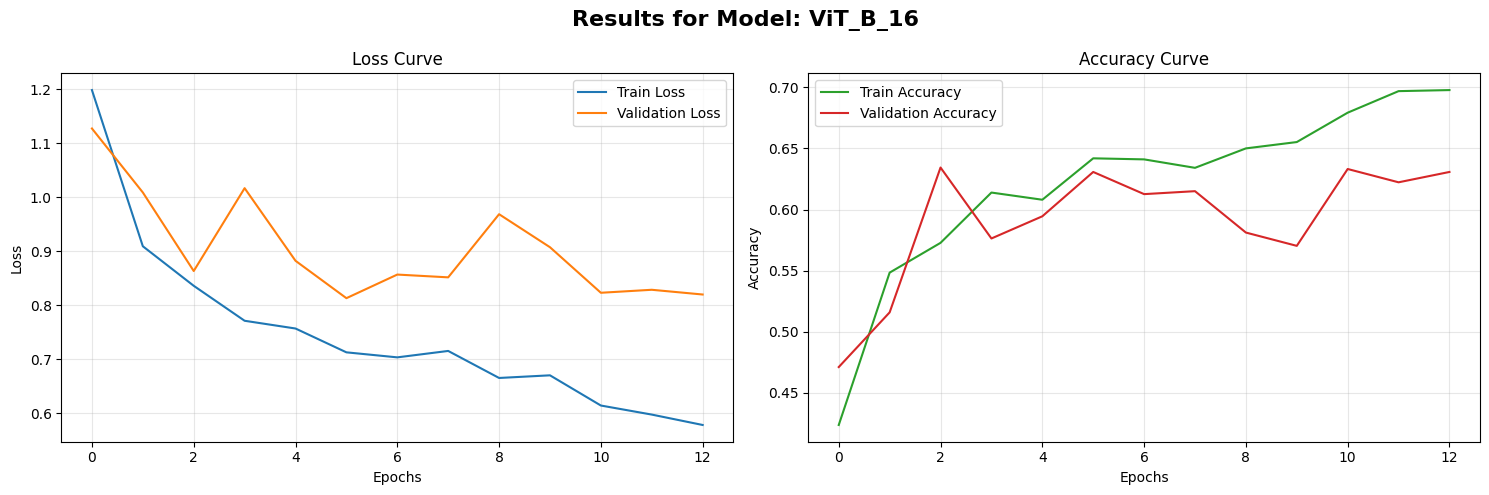

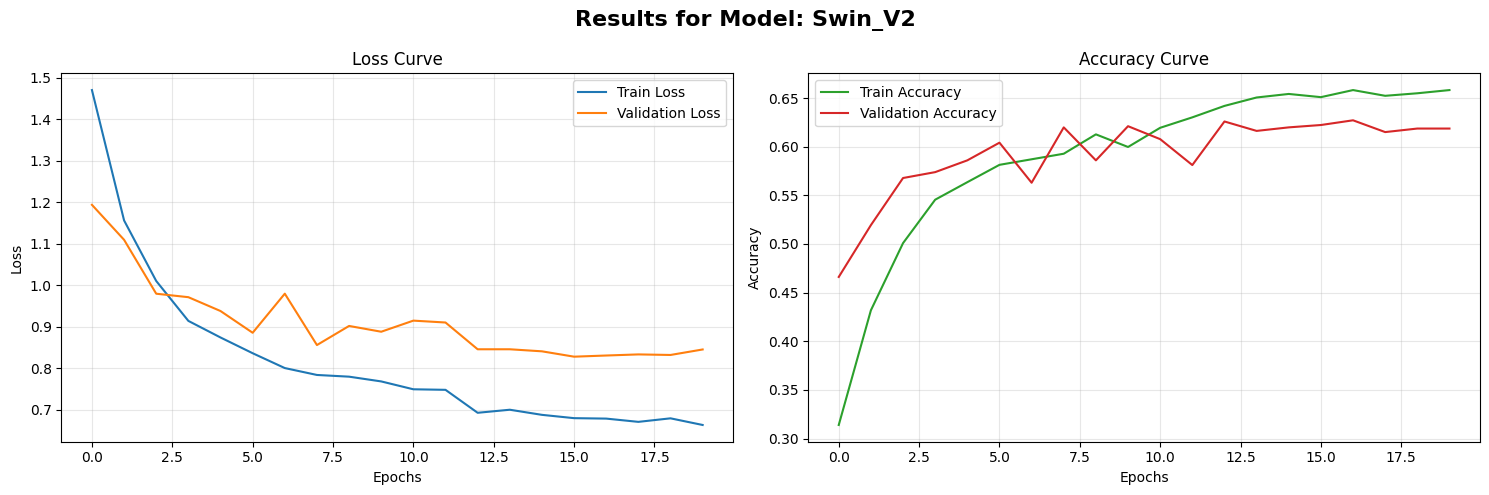

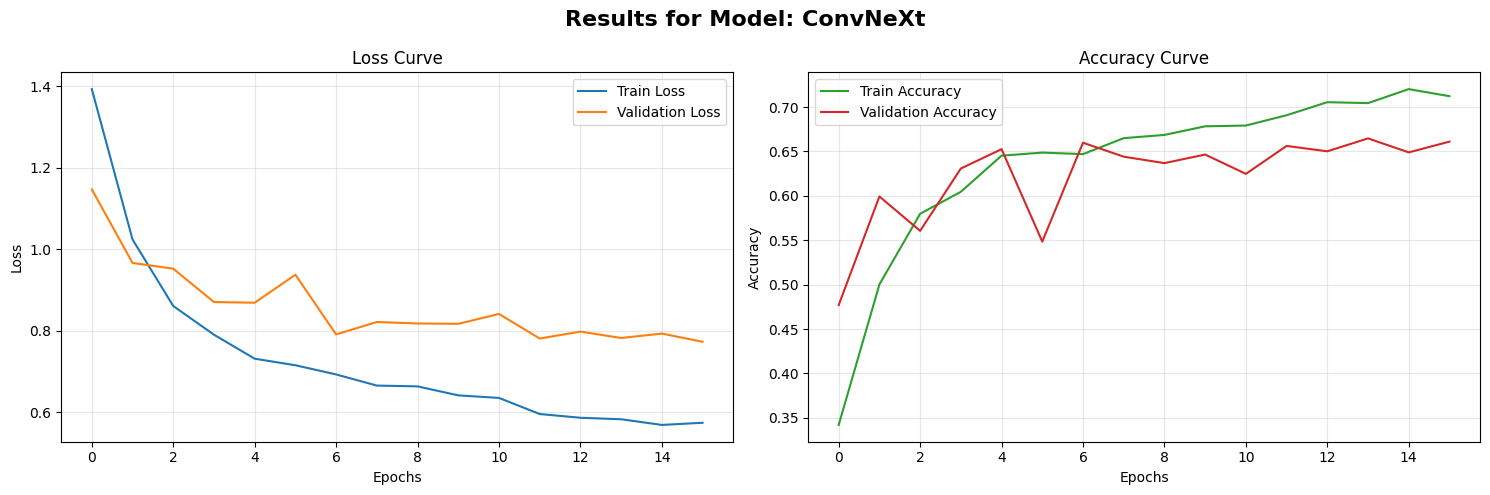

In [ ]:
for i, (name, _) in enumerate(model_list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Add a main title for the entire row (The Model Name)
    fig.suptitle(f"Results for Model: {name}", fontsize=16, fontweight='bold')

    # Plot Loss
    axes[0].plot(model_train_losses[i], label='Train Loss', color='tab:blue')
    axes[0].plot(model_val_losses[i], label='Validation Loss', color='tab:orange')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot Accuracy
    axes[1].plot(model_train_accuracies[i], label='Train Accuracy', color='tab:green')
    axes[1].plot(model_val_accuracies[i], label='Validation Accuracy', color='tab:red')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Adjust layout so titles don't overlap
    plt.tight_layout()
    plt.show()

In [ ]:
# Save each model
for i, (name, model) in enumerate(model_list):
    torch.save(model.state_dict(), f'best_model_{name}.pth')
    print(f"Model {name} saved!")

Model ViT_B_16 saved!
Model Swin_V2 saved!
Model ConvNeXt saved!


## Evaluate Model on Test Data

Tasks:
- Use trained model and evaluate on test_dataset
- Measure both accuracy and loss

In [ ]:
# Move the model to the device
best_all_preds = []
best_all_labels = []
best_all_probs = []

for name, model in model_list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Best model loaded and moved to {device}")

    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = []
    test_loss = 0.0

    # 1. Initialize counters
    correct_preds = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs.data, 1)

            # 2. Accumulate correct predictions and total count
            total_samples += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_test_loss = test_loss / len(test_dataset)

    # 3. Calculate accuracy
    epoch_test_acc = correct_preds / total_samples

    best_all_preds.append(all_preds)
    best_all_labels.append(all_labels)
    best_all_probs.append(all_probs)

    print(f"\nTest Loss: {epoch_test_loss:.4f}")
    print(f"Test Accuracy: {epoch_test_acc:.4f}") # Print the accuracy

Best model loaded and moved to cuda


Evaluating on Test Set: 100%|██████████| 52/52 [00:08<00:00,  6.00it/s]



Test Loss: 0.7365
Test Accuracy: 0.6806
Best model loaded and moved to cuda


Evaluating on Test Set: 100%|██████████| 52/52 [00:05<00:00,  9.70it/s]



Test Loss: 0.7575
Test Accuracy: 0.6552
Best model loaded and moved to cuda


Evaluating on Test Set: 100%|██████████| 52/52 [00:03<00:00, 14.48it/s]


Test Loss: 0.6910
Test Accuracy: 0.6981


## Compute Accuracy, Precision, Recall, F1 Score, and Confusion Matrix


Model Type: ViT_B_16

Test Accuracy: 0.6806
Test Precision (weighted): 0.6779
Test Recall (weighted): 0.6806
Test F1-Score (weighted): 0.6789

--- Per-Class Metrics ---
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       639
           1       0.38      0.37      0.37       296
           2       0.67      0.63      0.65       447
           3       0.80      0.84      0.82       223
           4       0.84      0.82      0.83        51

    accuracy                           0.68      1656
   macro avg       0.69      0.69      0.69      1656
weighted avg       0.68      0.68      0.68      1656



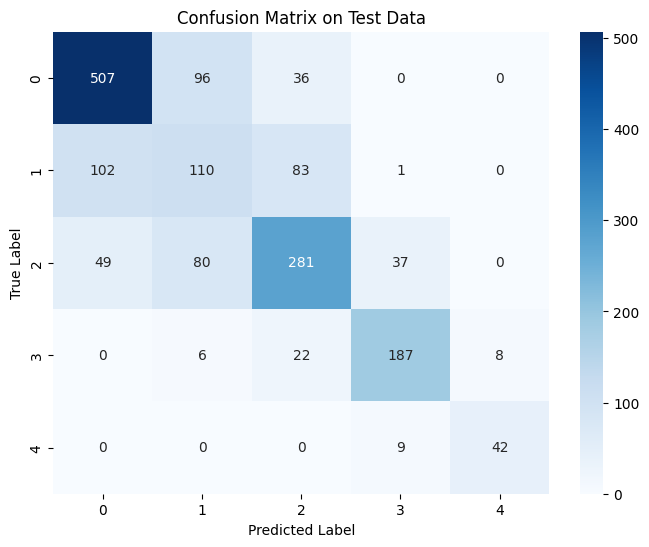


Model Type: Swin_V2

Test Accuracy: 0.6552
Test Precision (weighted): 0.6791
Test Recall (weighted): 0.6552
Test F1-Score (weighted): 0.6649

--- Per-Class Metrics ---
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       639
           1       0.33      0.43      0.37       296
           2       0.68      0.64      0.66       447
           3       0.80      0.78      0.79       223
           4       0.79      0.86      0.82        51

    accuracy                           0.66      1656
   macro avg       0.68      0.68      0.68      1656
weighted avg       0.68      0.66      0.66      1656



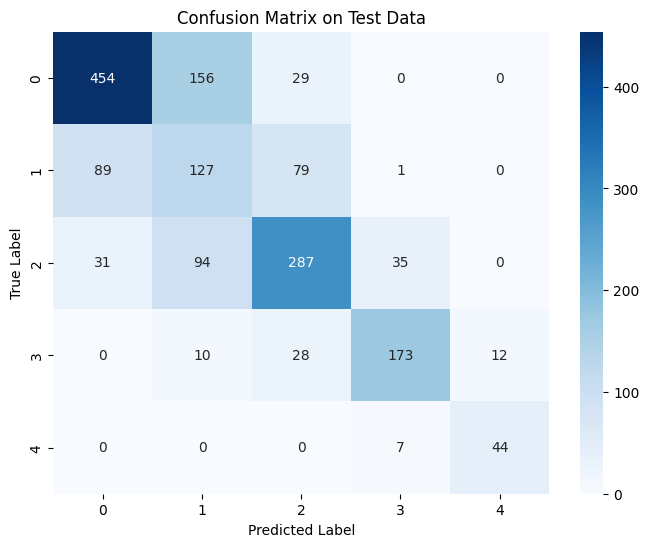


Model Type: ConvNeXt

Test Accuracy: 0.6981
Test Precision (weighted): 0.7063
Test Recall (weighted): 0.6981
Test F1-Score (weighted): 0.6997

--- Per-Class Metrics ---
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       639
           1       0.38      0.44      0.41       296
           2       0.75      0.61      0.67       447
           3       0.81      0.85      0.83       223
           4       0.92      0.86      0.89        51

    accuracy                           0.70      1656
   macro avg       0.73      0.71      0.72      1656
weighted avg       0.71      0.70      0.70      1656



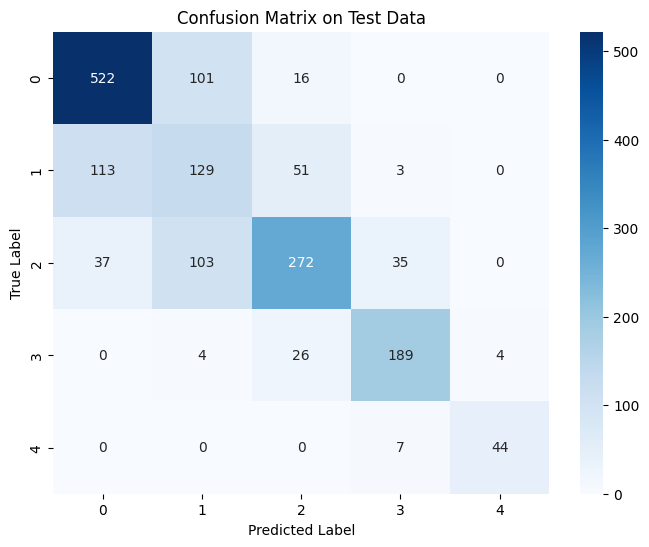

In [ ]:
# Convert lists to numpy arrays for scikit-learn functions

for i, (name, model) in enumerate(model_list):

    print(f"\nModel Type: {name}")

    all_labels_np = np.array(best_all_labels[i])
    all_preds_np = np.array(best_all_preds[i])
    all_probs_np = np.array(best_all_probs[i])

    # Calculate metrics
    accuracy = accuracy_score(all_labels_np, all_preds_np)
    precision = precision_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    recall = recall_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    f1 = f1_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels_np, all_preds_np)

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Precision (weighted): {precision:.4f}")
    print(f"Test Recall (weighted): {recall:.4f}")
    print(f"Test F1-Score (weighted): {f1:.4f}")

    report = classification_report(
        all_labels_np,
        all_preds_np,
        target_names=train_dataset.classes  # Ensures labels "0" to "4" are named correctly
    )

    print("\n--- Per-Class Metrics ---")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Test Data')
    plt.show()

    # NOTE: THIS IS EXTRA HERE
    classes = list(range(len(train_dataset.classes))) # [0, 1, 2, 3, 4]
    y_test_bin = label_binarize(all_labels_np, classes=classes)
    n_classes = y_test_bin.shape[1]

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], all_probs_np[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], all_probs_np[:, i])